In [1]:
# I - : Importing  the library and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,make_scorer
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from datetime import datetime
from keras.models import Sequential,load_model

In [2]:
# II - : Importing the training set

dataset=pd.read_csv("https://raw.githubusercontent.com/oreilly-mlsec/book-resources/599669c7124dffb65ea7f6e0b7626df32496b1d6/chapter3/datasets/cpu-utilization/cpu-full-b.csv", sep=",")

In [3]:
# III -  split of data Test & Training

# III.1 - : Size the data Test, Training
train_size=int(len(dataset)*.85)
test_size=int(len(dataset)*.15)
x_trainning,x_testing=dataset.iloc[0:train_size],dataset.iloc[(train_size+1):(train_size+test_size)]

In [4]:
# # III.1 - : Size the data Test, Training



In [5]:
# III.2 - : Data processing for  bidirectionnel,  conveNet1D et Random Forest

def TraitementDataModelEnsembleConVBidirRf(data,label,lags):
    df=data
    
    def create_features():# Creates time series features from datetime index
        df['date'] = pd.to_datetime(df.datetime)
        df['minute'] = df['date'].dt.minute
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.weekofyear
    
        X = df[['minute','hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
        y = df[label]
            
        return X,y
    
    def normalisationPreparationDonnee():
        dat=data[label].values
        X_RF,y=create_features()
        sc = MinMaxScaler(feature_range = (0, 1))
        data1= dat.reshape(-1,1)
        data2 = sc.fit_transform(data1)
        X_RF = sc.fit_transform(X_RF)
        x_train = []
        y_train = []
        x_trainRf=[]
        for i in range(lags,len(data2)):
            x_train.append(data2[i-lags:i, 0])
            y_train.append(data2[i, 0])
            x_trainRf.append(X_RF[i,:])
        return np.array(x_train,dtype=np.float32), np.array(y_train,dtype=np.float32),np.array(x_trainRf,dtype=np.float32)
    
    x_train, y_train,x_trainRf = normalisationPreparationDonnee()
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train,x_trainRf
 

In [6]:
x_train , y_train, x_trainRf= TraitementDataModelEnsembleConVBidirRf(x_trainning,label='cpu',lags=5)
x_test , y_test, x_testRf= TraitementDataModelEnsembleConVBidirRf(x_testing,label='cpu',lags=5)

<ipython-input-5-e9bbf6914e7b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df.datetime)
<ipython-input-5-e9bbf6914e7b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df['date'].dt.minute
<ipython-input-5-e9bbf6914e7b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [7]:
# IV - Importing the  differents MODELS

modelRandom=load('modelRandomProj.pkl')
modelConvNet1D = load_model('modelConvNet1DProj.h5')
modelbidir = load_model('modelRnnBidirectionalProj.h5')
modelLSTM = load_model('modelRnnLSTMProj.h5')
modelbidir = load_model('modelRnnBidirectionalProj.h5')


C:\Users\lucgo\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\lucgo\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [8]:
#  V - : Calcul des erreurs et Affichage des ajustements du modèle 
#  sur les données d'Entrainement et de Test

def ErreurPrediction(Nommodele,data,prediction ):
    print('La R^2-Squared(r2_score) du modèle {} est : {}'.format(Nommodele,r2_score(data,prediction)))
    print('La MSE modèle {} est de: {} '.format(Nommodele,mean_squared_error(data,prediction)))
    print('RMSE est:{}'.format(np.sqrt(mean_squared_error(data,prediction))))
    
# Affichage_Model(modelLSTM,NomDumodele)

def affichage(modDataTraining,modDataTesting):
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.plot(y_train, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(modDataTraining, color = 'blue', label = 'Prédiction du modèle Ensemble convNet2D + RNN-Bidiectionnel')
    plt.title('Ajustement Données Entrainement')
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(y_test, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(modDataTesting, color = 'blue', label = 'Prédiction du modèle Ensemble convNet2D + RNN-Bidiectionnel')
    plt.title('Ajustement :Données test')
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()

In [9]:
# VI : Modèle ensembliste bidirectionnel et conveNet1D

# VI.1 : Modèle ensembliste avec ponderation 50%

mod=0.5*(modelConvNet1D.predict(x_train) + modelbidir.predict(x_train)) 

modtest=0.5*(modelConvNet1D.predict(x_test) + modelbidir.predict(x_test)) 


In [10]:
ErreurPrediction("Erreur données Entrainement",y_train,mod)

La R^2-Squared(r2_score) du modèle Erreur données Entrainement est : 0.9716649149752495
La MSE modèle Erreur données Entrainement est de: 0.0017580364365130663 
RMSE est:0.04192894324660301


In [11]:
ErreurPrediction("Erreur données test",y_test,modtest)

La R^2-Squared(r2_score) du modèle Erreur données test est : 0.8243736013938558
La MSE modèle Erreur données test est de: 0.01365640852600336 
RMSE est:0.11686063557863235


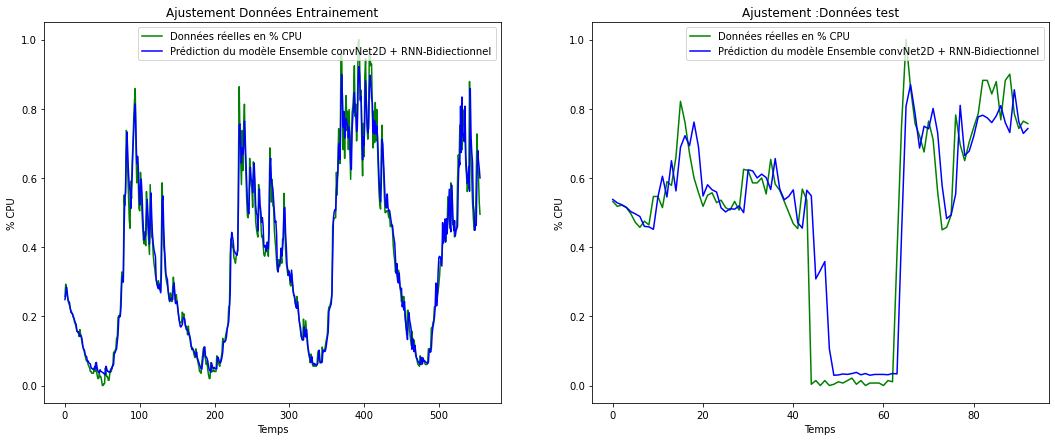

In [12]:
affichage(mod,modtest)

In [13]:
# VI.2 : Modèle ensembliste avec meilleures pondérations

In [27]:
# Recherche des meilleures pondérations
a=np.arange(0,100,5)
b=np.arange(0,100,5)
for i in a:
    for j in b:
        if (i+j==100) :
            modelTrain=(i/100)*(modelConvNet1D.predict(x_train)) + (j/100)*(modelbidir.predict(x_train))
            modelTest=(i/100)*(modelConvNet1D.predict(x_test)) + (j/100)*(modelbidir.predict(x_test))
            if ((r2_score(y_train,modelTrain)>0.97)&(r2_score(y_test,modelTest)>0.84)):
                print(i,j,r2_score(y_train,modelTrain),r2_score(y_test,modelTest))
                
                       
                

5 95 0.9766443642368773 0.8462031480428365
10 90 0.9776003382756332 0.8479995853453003
15 85 0.9781790012962434 0.8487405235283618
20 80 0.9783803536037183 0.848425991183431
25 75 0.9782043938597217 0.8470559673551329
30 70 0.9776511195733523 0.844630469329817
35 65 0.9767205369007781 0.8411494792822176


La R^2-Squared(r2_score) du modèle Erreur données Entrainement est : 0.9781790012962434
La MSE modèle Erreur données Entrainement est de: 0.001353873056359589 
RMSE est:0.03679501265287399
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.8487405235283618
La MSE modèle Erreur données test est de: 0.011761676520109177 
RMSE est:0.10845126211643219


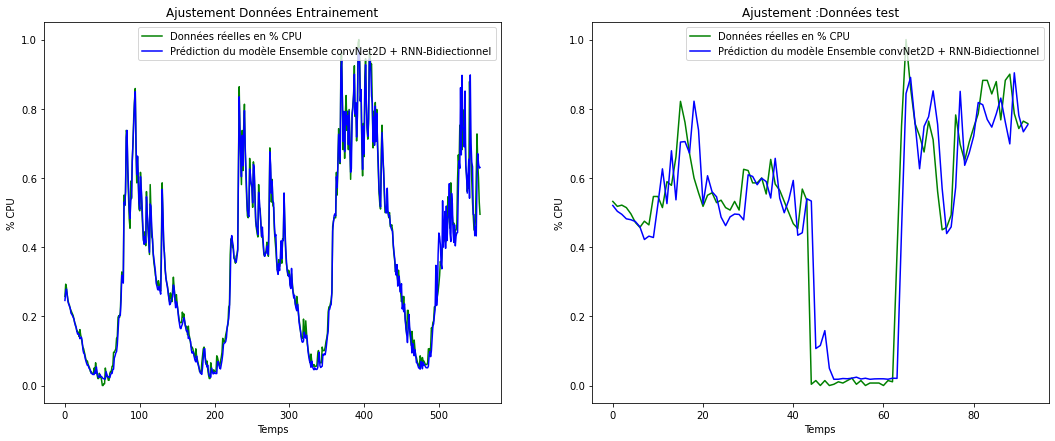

In [32]:
# la meilleure pondération ici est  15(CONVNET) et 85(BIDIR) ou 20 et 80 si on tient compte des performances sur les données Test.

mod1=0.15*modelConvNet1D.predict(x_train) + 0.85*modelbidir.predict(x_train) 

modtest1=0.15*modelConvNet1D.predict(x_test) + 0.85*modelbidir.predict(x_test) 
ErreurPrediction("Erreur données Entrainement",y_train,mod1)
ErreurPrediction("Erreur données test",y_test,modtest1)
affichage(mod1,modtest1)

In [37]:
# VII : Modèle ensembliste bidirectionnel, conveNet1D et random forest

In [41]:
Rf=RandomForestRegressor
modelRandom=Rf(n_estimators=300,max_depth=10, random_state=0)
modelRandom.fit(x_trainRf, y_train)

RandomForestRegressor(max_depth=10, n_estimators=300, random_state=0)

les erreurs sur les données sont données ci-dessous:
La R^2-Squared(r2_score) du modèle Erreur données Entrainement est : 0.981846394486914
La MSE modèle Erreur données Entrainement est de: 0.0011263316264376044 
RMSE est:0.0335608646273613
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.5470142178625101
La MSE modèle Erreur données test est de: 0.035223398357629776 
RMSE est:0.1876789778470993


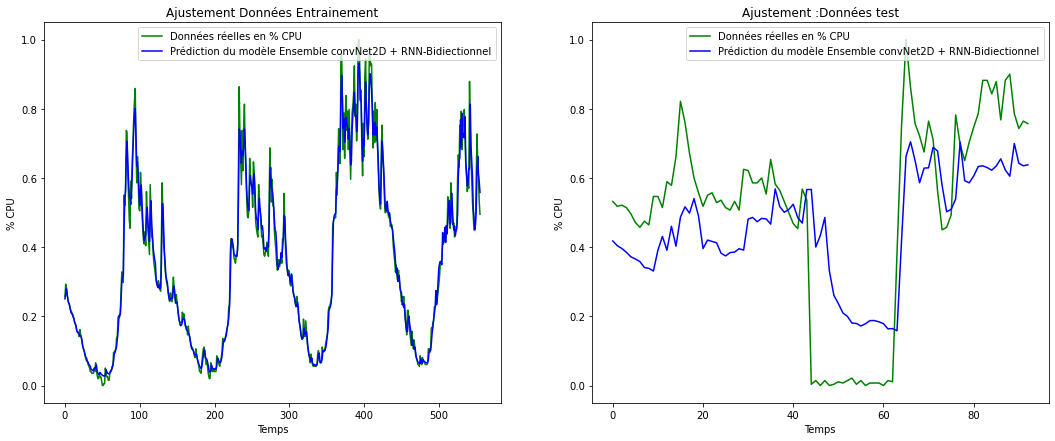

In [58]:
# VII.1 : Modèle ensembliste avec ponderation 33%
# ici, nous allons d'abord convertir  les sorties du modele random forest en format float 32 , puis utiliser reshape(-1,1)

mod2=0.33*(modelConvNet1D.predict(x_train)) + 0.33*(modelbidir.predict(x_train)) + 0.33*(np.array(modelRandom.predict(x_trainRf),dtype=np.float32).reshape(-1,1)) 

modtest2=0.33*(modelConvNet1D.predict(x_test)) + 0.33*(modelbidir.predict(x_test)) + 0.33*(np.array(modelRandom.predict(x_testRf),dtype=np.float32).reshape(-1,1)) 

print('les erreurs sur les données sont données ci-dessous:')

ErreurPrediction("Erreur données Entrainement",y_train,mod2)
ErreurPrediction("Erreur données test",y_test,modtest2)
affichage(mod2,modtest2)

In [60]:
# Recherche des meilleures pondérations du Modèle ensembliste bidirectionnel, conveNet1D et random forest
a=np.arange(0,100,5)
b=np.arange(0,100,5)
for i in a:
    for j in b:
        for k in b:
            if (i+j+k==100):
                modelTrain=(i/100)*(modelConvNet1D.predict(x_train)) + (j/100)*(modelbidir.predict(x_train)) + (k/100)*(np.array(modelRandom.predict(x_trainRf),dtype=np.float32).reshape(-1,1))
                modelTest=(i/100)*(modelConvNet1D.predict(x_test)) + (j/100)*(modelbidir.predict(x_test)) + (k/100)*(np.array(modelRandom.predict(x_testRf),dtype=np.float32).reshape(-1,1))
                if ((r2_score(y_train,modelTrain)>0.97)&(r2_score(y_test,modelTest)>0.84)):
                    print(i,j,k,r2_score(y_train,modelTrain),r2_score(y_test,modelTest))
                
                       

5 95 0 0.9766443642368773 0.8462031480428365
10 85 5 0.9793959636022097 0.8401779874498737
10 90 0 0.9776003382756332 0.8479995853453003
15 85 0 0.9781790012962434 0.8487405235283618
20 80 0 0.9783803536037183 0.848425991183431
25 75 0 0.9782043938597217 0.8470559673551329
30 70 0 0.9776511195733523 0.844630469329817
35 65 0 0.9767205369007781 0.8411494792822176


In [61]:
# les meilleures ponderations en tenant comptye des performances sur les données Tests sont données par: 10 % 85% 5%

les erreurs sur les données sont données ci-dessous:
La R^2-Squared(r2_score) du modèle Erreur données Entrainement est : 0.9793959636022097
La MSE modèle Erreur données Entrainement est de: 0.0012783671263605356 
RMSE est:0.035754259675741196
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.8401779874498737
La MSE modèle Erreur données test est de: 0.012427487410604954 
RMSE est:0.11147864162921906


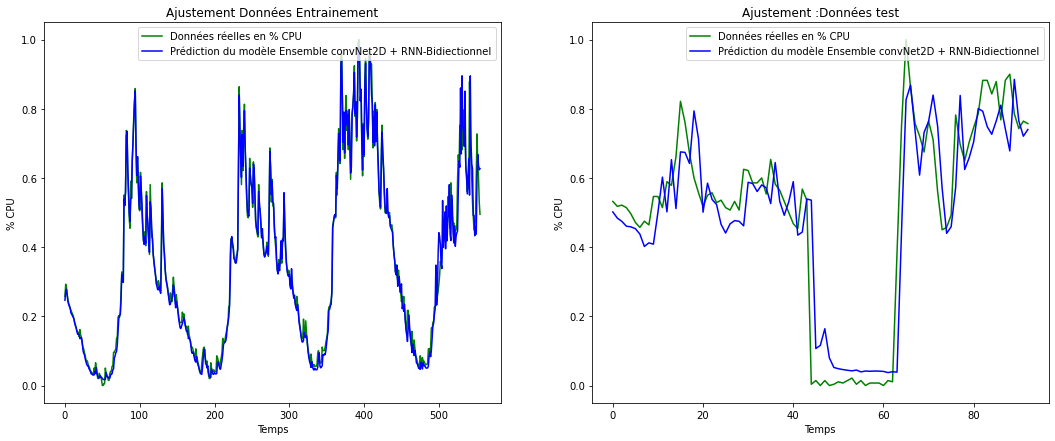

In [62]:
mod3=0.10*(modelConvNet1D.predict(x_train)) + 0.85*(modelbidir.predict(x_train)) + 0.05*(np.array(modelRandom.predict(x_trainRf),dtype=np.float32).reshape(-1,1)) 

modtest3=0.10*(modelConvNet1D.predict(x_test)) + 0.85*(modelbidir.predict(x_test)) + 0.05*(np.array(modelRandom.predict(x_testRf),dtype=np.float32).reshape(-1,1)) 
print('les erreurs sur les données sont données ci-dessous:')

ErreurPrediction("Erreur données Entrainement",y_train,mod3)
ErreurPrediction("Erreur données test",y_test,modtest3)
affichage(mod3,modtest3)

In [63]:
# on obtient le même resultat que la modelisation precedente.